# TCGA Multi-Omics API Demo

### 1. Connect to the instance

In [2]:
lapply(X = c('tidyverse', 'magrittr', 'integrationCurator', 'survival', 'survminer'),
       FUN = require, character.only = TRUE)

Sys.setenv(PRED_SPOT_HOST = 'occam.genestack.com',
           PRED_SPOT_TOKEN = '<token>', 
           PRED_SPOT_VERSION = 'default-released')

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

### 2. Get individuals from TCGA LUAD project

In [3]:
system.time({
  samples <-
    OmicsQueriesApi_search_samples(
      study_filter = '"Study Title"="TCGA-LUAD"',
      sample_filter = 'gender=male') %>%
    extract2('content') %>%
    extract2('data') %>%
    extract2('metadata')
    
}) %>% extract('elapsed') %>% signif(digits = 2) %>% paste('Time taken to get', nrow(samples), 'samples:', ., 'seconds.')

# Filter out NAs
samples %<>%
  as_tibble %>%
  filter(survival != 'NA') %>%
  filter(survival != 0) %>%
  select_if(~sum(!is.na(.)) > 0)
head(samples)

[1] "Time taken to get 242 samples: 0.77 seconds."

genestack:accession,Sample Source ID,smoking_status,gender,pack_years_smoked,days_to_last_follow_up,primary_diagnosis,case_id,race,vital_status,survival,age_at_index,Sample Source,days_to_death
GSF994319,TCGA-38-4632,Yes,male,10.0,NA,"Adenocarcinoma, NOS",875333ab-9048-462d-aaa2-693ad127e3cc,black or african american,Dead,1357,42,TCGA-LUAD,1357
GSF994320,TCGA-95-8039,No,male,NA,830,Acinar cell carcinoma,87f1b3df-4bc7-4336-b658-f30ac1c5c796,white,Alive,830,72,TCGA-LUAD,NA
GSF994316,TCGA-86-8076,No,male,NA,993,"Papillary adenocarcinoma, NOS",8609edfc-119d-4d63-9188-c86aabd5ca52,white,Alive,993,42,TCGA-LUAD,NA
GSF994327,TCGA-05-5420,Yes,male,40.0,457,"Adenocarcinoma, NOS",8b119d1c-6d21-4bbd-8a00-12da7b97d6c4,not reported,Alive,457,67,TCGA-LUAD,NA
GSF994328,TCGA-97-8174,Yes,male,40.0,NA,"Papillary adenocarcinoma, NOS",8c695c24-e7f9-449a-9258-a1bc8a33bf9a,white,Dead,164,67,TCGA-LUAD,164
GSF994329,TCGA-MP-A4SY,Yes,male,40.0,NA,"Adenocarcinoma, NOS",8cc6bcec-65df-46a9-a88c-09762a132857,white,Dead,1501,61,TCGA-LUAD,1501


### 3. Survival by smoking status

In [4]:
samples %>%
  group_by(smoking_status) %>%
  summarise(mean(as.numeric(survival))) %>%
  set_colnames(c('Smoker', 'Mean Survival (Days)'))

`summarise()` ungrouping output (override with `.groups` argument)


Smoker,Mean Survival (Days)
No,933.1739
Yes,922.7771


### 4. Get KRAS mutations

In [5]:
system.time({
  
  variants <-
    OmicsQueriesApi_search_variant_data(
      study_filter = '"Study Title"="TCGA-LUAD"',
      sample_filter = 'gender=male',
      vx_query = 'Gene=KRAS', 
      page_limit = 10000) %>%
    extract2('content') %>%
    extract2('data') %>%
    as_tibble
  
}) %>%
  extract('elapsed') %>% signif(digits = 3) %>% paste('Time taken to get', nrow(variants), 'genotypes:', ., 'seconds.')

variants %>% 
  mutate_at(c('alteration', 'variationId'), unlist) %>%
  print

[1] "Time taken to get 2489 genotypes: 0.99 seconds."

# A tibble: 2,489 x 10
   itemId metadata$`Softw… contig  start reference alteration variationId
   <chr>  <chr>            <chr>   <int> <chr>     <chr>      <chr>      
 1 GSF99… VarScan          12     2.52e7 C         G          .          
 2 GSF99… VarScan          12     2.52e7 C         G          .          
 3 GSF99… VarScan          12     2.52e7 C         G          .          
 4 GSF99… VarScan          12     2.52e7 C         G          .          
 5 GSF99… VarScan          12     2.52e7 C         G          .          
 6 GSF99… VarScan          12     2.52e7 C         G          .          
 7 GSF99… VarScan          12     2.52e7 C         G          .          
 8 GSF99… VarScan          12     2.52e7 C         G          .          
 9 GSF99… VarScan          12     2.52e7 C         G          .          
10 GSF99… VarScan          12     2.52e7 C         G          .          
# … with 2,479 more rows, and 7 more variables: info$AC <list>, $AN <list>,
#   genotype$

### 5. Survival by KRAS mutation status

In [7]:
variants <- normaliseVariants(variants)

samples <- inner_join(samples, variants, by = 'Sample Source ID') 
samples %>%
  group_by(SNP) %>%
  summarise(mean(as.numeric(survival))) %>%
  set_colnames(c('SNP', 'Mean Survival (Days)'))

`summarise()` ungrouping output (override with `.groups` argument)


SNP,Mean Survival (Days)
No,915.3689
Yes,816.7037


### 6. Get KRAS expression values

In [8]:
system.time({
  
  expression <-
    OmicsQueriesApi_search_expression_data(
      study_filter = '"Study Title"="TCGA-LUAD"',
      sample_filter = 'gender=male',
      ex_query = 'Gene=KRAS MinValue=0',
      ex_filter = 'Type=FPKM') %>%
    extract2('content') %>%
    extract2('data') %>%
    as_tibble
  
}) %>% extract('elapsed') %>% signif(digits = 3) %>% paste('Time taken to get', nrow(expression), 'expression values:', ., 'seconds.')

print(head(expression))

[1] "Time taken to get 219 expression values: 0.274 seconds."

# A tibble: 6 x 7
  itemId metadata$Type $`Run Source ID` runId groupId gene  expression
  <chr>  <chr>         <chr>            <chr> <chr>   <chr>      <dbl>
1 GSF99… FPKM          TCGA-05-4244     GSF9… GSF994… KRAS       12.4 
2 GSF99… FPKM          TCGA-05-4249     GSF9… GSF994… KRAS       31.6 
3 GSF99… FPKM          TCGA-05-4382     GSF9… GSF994… KRAS       10.7 
4 GSF99… FPKM          TCGA-05-4384     GSF9… GSF994… KRAS        9.37
5 GSF99… FPKM          TCGA-05-4389     GSF9… GSF994… KRAS        9.07
6 GSF99… FPKM          TCGA-05-4395     GSF9… GSF994… KRAS       17.1 
# … with 1 more variable: relationships$sample <chr>


### 7. Survival by KRAS over/under expression

In [9]:
expression[, 2] <- expression$metadata$`Run Source ID`
colnames(expression)[2] <- 'Sample Source ID'

# Divide patients into two expression groups.
samples <- 
  inner_join(samples, expression, by = 'Sample Source ID') %>%
  { cbind(., 'regulation' = ifelse(.$expression > median(.$expression), 'Over', 'Under')) }

samples %>%
  group_by(regulation) %>%
  summarise(mean(as.numeric(survival))) %>%
  set_colnames(c('Expression', 'Mean Survival (Days)'))

`summarise()` ungrouping output (override with `.groups` argument)


Expression,Mean Survival (Days)
Over,795.4699
Under,961.7711


### 8. Survival by KRAS copy number alterations

In [10]:
system.time({
  
  copy.number <-
    OmicsQueriesApi_search_expression_data(
      study_filter = '"Study Title"="TCGA-LUAD"',
      sample_filter = 'gender=male',
      ex_query = 'Gene=KRAS MinValue=0',
      ex_filter = 'Type="Copy Number"') %>%
    extract2('content') %>%
    extract2('data') %>%
    as_tibble
  
}) %>% extract('elapsed') %>% signif(digits = 3) %>% paste('Time taken to get', nrow(copy.number), 'copy number values:', ., 'seconds.')

copy.number[, 2] <- copy.number$metadata$`Run Source ID`
colnames(copy.number)[2] <- 'Sample Source ID'
samples <-
  inner_join(samples, copy.number, by = 'Sample Source ID') %>%
  { cbind(., 'copies' = ifelse(.$expression.y >4, 'High CNA', 'Low CNA')) }

samples %>%
  group_by(copies) %>%
  summarise(mean(as.numeric(survival))) %>%
  set_colnames(c('Copy Number Abberation', 'Mean Survival (Days)'))

[1] "Time taken to get 217 copy number values: 0.246 seconds."

`summarise()` ungrouping output (override with `.groups` argument)


Copy Number Abberation,Mean Survival (Days)
High CNA,611.5556
Low CNA,959.6032


### 6. Survival curve for based on smoking status and multi-omics marker 

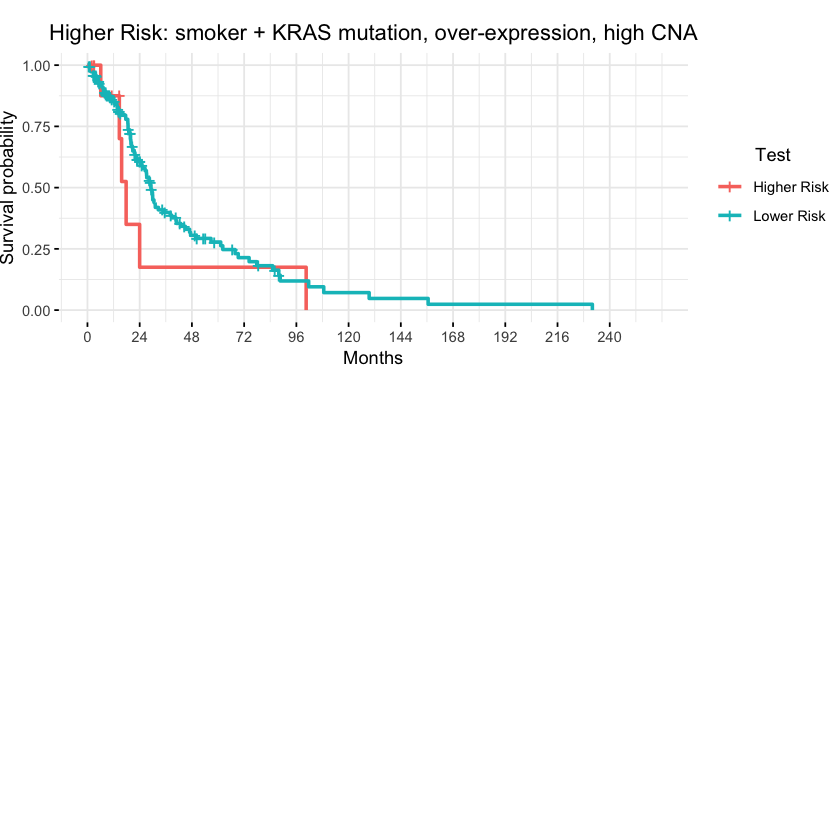

In [11]:
risk_group <-
  apply(X = samples, MARGIN = 1, FUN = function(x) {
    if ( sum(x['smoking_status'] == 'Yes', 
             x['SNP'] == 'Yes', 
             x['regulation'] == 'Over', 
             x['copies'] == 'High CNA') == 4 ) { 'High' } else { 'Low' }
  })
# Quick stratification of patients into high and low-risk groups.
data <- {
  samples %>%
    { data.frame(as.numeric(.[, 'survival']),
                 ifelse(.[, 'vital_status'] == 'Dead', 0, 1),
                 risk_group) } %>%
    `colnames<-`(c('Time', 'Status', 'Risk'))
}
fit <- { 
  survfit(formula = Surv(time = Time, event = Status) ~ Risk,
                 data = data) }
# Compute Kaplan-Meier curve data for binary risk groups.
ggsurvplot(fit = fit,
           data = data,
           xscale = 'd_m',
           break.x.by = 730.5,
           xlab = 'Months',
           legend = 'right',
           legend.title = 'Test',
           legend.labs = c('Higher Risk', 'Lower Risk'),
           ggtheme = theme_minimal() +
             theme(plot.title = element_text(hjust = 0.5), plot.margin = unit(c(0.5,0,10,0),"cm"),
                   legend.title.align = 0.5)) +
  labs(title = paste('Higher Risk: smoker + KRAS mutation, over-expression, high CNA'))
# Plot survival curve for multi-omics stratification groups.

In [6]:
normaliseVariants <- function(variants) {
  variants$genotype$GT %<>% { ifelse(test = . == './.', yes = '0/0', no = .) }
    
  # Assume genotype 0/0 for no information.
  normalisedVariants = lapply(X = unique(variants$start), FUN = function(rs) {
    
    SNP <- dplyr::filter(variants, start == rs)
    # Filter the table down to just one SNP at a time.
    
    if ( length(unique(SNP$genotype$sampleNames)) != nrow(SNP) ) {
      # If the number of rows and number of unique sample IDs don't match:
      
      
      lapply(X = unique(SNP$genotype$sampleNames), FUN = function(patient) {
        
        dplyr::filter(SNP$genotype, sampleNames == patient) %>%
          dplyr::select(GT) %>%
          table %>%
          { if ( length(.) == 1 ) { return(c('SNP' = rs, 'sampleNames' = patient, 'GT' = '0/0')) }
            else if ( length(.) == 2 ) { return(c('SNP' = rs, 'sampleNames' = patient, 'GT' = '0/1')) }
            else if ( length(.) == 3 ) { return(c('SNP' = rs, 'sampleNames' = patient, 'GT' = '1/1')) }}
        # Rough and ready way to compress multiple base variants for the same SNP.
        
      }) %>%
        do.call('rbind', .)
      
    } else { 
      
      cbind(rs, SNP$genotype[, c('sampleNames', 'GT')]) %>%
        set_colnames(c('SNP', 'sampleNames', 'GT')) %>%
        return
      
    }
    
  }) %>%
  do.call('rbind', .) %>%
  { lapply(X = unique(.$sampleNames), 
           FUN = function(patient) {
             
             dplyr::filter(., sampleNames == patient) %>%
               dplyr::select(GT) %>%
               unlist %>%
               { if ( all(. == '0/0') ) { c('Sample Source ID' = patient, 'SNP' = 'No') } else { c('Sample Source ID' = patient, 'SNP' = 'Yes') } }
               
           }) } %>%
  do.call('rbind', .) %>%
  as_tibble
    
    return(normalisedVariants)
}